# ENGE

* Valor Agregado Bruto en millones de pesos (ajustado por IPI)
* Empleo en cantidad de ocupados

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import os
from unidecode import unidecode


# ENGE pre 2016

In [2]:
#cargo y limpio data
# vab_1 = pd.read_csv('./enge - producto.csv', skiprows=2)
# emp_1 = pd.read_csv('./enge - empleo.csv', skiprows=2)
vab_1 = pd.read_csv('./enge (silber) - producto.csv', skiprows=2)
emp_1 = pd.read_csv('./enge (silber) - empleo.csv', skiprows=2)
# emp_1 = emp_1.replace('.', '', regex=True)


def replace_points(df):
    # Iterate over each column
    for col in df.columns:
        if df[col].dtype == 'float':
            df[col] = df[col].astype(str).str.replace('.', '').astype(int)
            
    return df

def clean_col (df, col):
    df = df.replace(',', '', regex=True)

    df.columns = [ x.replace('  ', '').replace('\n', '').strip() for x in  df.columns]
        
    # Get the current column names
    # column_names = df.columns.tolist()
    # # print(column_names)
    # # Specify the index of the column you want to rename
    # column_index = 0
    # # Set the new column name at the specified index
    # column_names[column_index] = 'year'
    # Update the column names in the DataFrame
    # df.columns = column_names

    print(df.columns)
    df = df.melt(id_vars = 'year')
    df.rename(columns = {'value': col,
                        'variable': 'sector',
                        }, inplace = True)
    df = df.dropna(subset=[col])
    print(f'unque sectors: {len(df.sector.unique())}')
    #filtro año 2016 pero habria q buscarlo
    df = df[df['year'] <= 2016]
    df[col] = df[col].astype(float) if col == 'vab' else df[col].astype(int)
    
    return df


# emp_1 = replace_points(emp_1)#

    
emp_1 = clean_col(emp_1, 'emp')
vab_1 = clean_col(vab_1, 'vab')

print(emp_1.info(), vab_1.info() )


Index(['year', 'Total', 'Minas y canteras', 'Total Manufactura',
       'Alimentos, bebidas y tabaco', 'Combustibles, químicos y plásticos',
       'Maquinarias, equipos y vehículos', 'Resto industria (1)',
       'Total Servicios', 'Electricidad, gas y agua', 'Comunicaciones',
       'Resto actividades (2)'],
      dtype='object')
unque sectors: 11
Index(['year', 'Total', 'Minas y canteras', 'Total Manufactura',
       'Alimentos, bebidas y tabaco', 'Combustibles, químicos y plásticos',
       'Maquinarias, equipos y vehículos', 'Resto industria (1)',
       'Total Servicios', 'Electricidad, gas y agua', 'Comunicaciones',
       'Resto actividades (2)'],
      dtype='object')
unque sectors: 11
<class 'pandas.core.frame.DataFrame'>
Int64Index: 264 entries, 0 to 263
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   year    264 non-null    int64 
 1   sector  264 non-null    object
 2   emp     264 non-null    int32 
dtypes: int3

In [3]:
#joineo
data_1 = pd.merge(vab_1,
         emp_1,
         how = 'left', 
         on = ['year', 'sector'])

data_1['sector'] = data_1['sector'].apply(unidecode)

len(data_1.sector.unique())

11

In [4]:
data_1[data_1['year']==2016]

,year,sector,vab,emp
23,2016,Total,1324396.0,834861
47,2016,Minas y canteras,194422.0,42209
71,2016,Total Manufactura,664423.0,315821
95,2016,"Alimentos, bebidas y tabaco",276573.0,137543
119,2016,"Combustibles, quimicos y plasticos",228773.0,64165
143,2016,"Maquinarias, equipos y vehiculos",82405.0,55187
167,2016,Resto industria (1),76672.0,58926
191,2016,Total Servicios,465550.0,476831
215,2016,"Electricidad, gas y agua",79230.0,51300
239,2016,Comunicaciones,129324.0,67784


In [5]:
# data_1['productividad'] = data_1.vab/data_1.emp
# data_1

# ENGE post 2016

In [6]:
#cargo data

# Get the current working directory
current_directory = os.getcwd()

# Print the current working directory
print("Current directory:", current_directory)

# List files in the current directory
def get_enge_data_2(current_directory):
    files = os.listdir(current_directory+ "\\raw_data\\")
    data = pd.DataFrame()
    total_len = 0
    for file in files:
        if '.xls' in file: 
            print(f'file {file}')
            # print(file)
            year = file.split('.')[0].split('_')[-1].strip()
            # print(year)
            # Specify the file path
            file_path =  current_directory + "\\raw_data\\" + file

            # Specify the sheet name or index
            sheet_name = 'C11'  # You can also use the sheet index (0, 1, 2, etc.)

            # Read the Excel file
            df = pd.read_excel(file_path, sheet_name=sheet_name, skiprows  = 2
                              # ,engine='openpyxl'
                              )


            # Rename the columns starting with 'Unnamed'
            df.rename(columns=lambda x: df.iloc[0][x] if 'Unnamed' in str(x) else x, inplace=True)
            df.rename(columns={'Componente': 'componente', 
                               'Unidad de medida': 'unidad',
                    'Electricidad, gas, agua, residuos y saneamiento' : 'Electricidad, gas y agua',
                    'Servicios de información y comunicaciones': 'Comunicaciones',
                    'Industria manufacturera': 'Total Manufactura'
                    }, inplace = True)
            
            # Drop the first two rows
            df = df.drop([0, 1]).reset_index(drop=True)

            
            df = df.melt(id_vars = ['componente', 'unidad'], var_name = 'sector')

            # Filter rows that start with "Fuente"
            df.dropna(subset = ['componente'], inplace = True)
            df = df[~df['componente'].str.startswith('Fuente')  & df['componente'].notna()]

            df['year']= year    

            total_len += len(df)

            data = pd.concat([df, data])

    print(total_len)
    return data
data = get_enge_data_2(current_directory)
data.info()

Current directory: c:\Users\mateo\Documents\repos\productivity_measures\enge
file sh_enge_2012_2017.xls
file sh_enge_2014_2018.xls
file sh_enge_2015_2019.xls
file sh_enge_2016_2020.xls
file sh_enge_2017_2021.xlsx
1050
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1050 entries, 0 to 237
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   componente  1050 non-null   object
 1   unidad      1050 non-null   object
 2   sector      1050 non-null   object
 3   value       1050 non-null   object
 4   year        1050 non-null   object
dtypes: object(5)
memory usage: 49.2+ KB


In [7]:
#calculo el index 

def get_index(df):
    # print(df.columns)
    # Pivot the dataframe
    pivot_df = df.pivot(values='value', index=['sector', 'year'], columns='componente')#.reset_index()#.drop(['componente'], axis =1)
    print(f'pivot_df.columns {pivot_df.columns}')    

    # Calculate the ratio
    # pivot_df['productividad'] = pivot_df['Valor agregado bruto'] / pivot_df['Puestos de trabajo asalariados']
    pivot_df['tasa_rentabilidad'] = pivot_df['Utilidad'] / pivot_df['Activo'] *100

    pivot_df.rename(columns = {'Valor agregado bruto': 'vab',
                              'Puestos de trabajo asalariados' : 'emp',
                              }, inplace = True)
    
    # print(pivot_df.columns)
    pivot_df.reset_index(inplace= True)
    pivot_df = pivot_df[['year', 'sector', 'vab' , 'emp' ]] # 'productividad'
    
    pivot_df['sector'] = pivot_df['sector'].apply(unidecode)

    return pivot_df.reset_index()
data_2  = get_index(data)

pivot_df.columns Index(['Activo', 'Amortizaciones', 'Cantidad de empresas',
       'Excedente neto de explotación', 'Exportaciones',
       'Formación bruta de capital fijo', 'Importaciones',
       'Impuestos sobre la producción', 'Patrimonio neto',
       'Puestos de trabajo asalariados', 'Salarios', 'Utilidad',
       'Valor agregado bruto', 'Valor bruto de la producción'],
      dtype='object', name='componente')


In [8]:
data_2.head(3)
# data_2.reset_index()
# data_2.index#iloc[:,1: ]#.index

componente,index,year,sector,vab,emp
0,0,2017,"Alimentos, bebidas y tabaco",318010.524911,137557
1,1,2018,"Alimentos, bebidas y tabaco",526944.771732,133637
2,2,2019,"Alimentos, bebidas y tabaco",787440.418027,130560


In [9]:
#veo los sectores presentes en cada conjunto de datos
dict_sectors = {}
for df_i, nam_i in zip([data_1, data_2 ], ['data_1', 'data_2']):
    unique_sectors = df_i.sector.unique()
    print(nam_i)
    # print(unique_sectors)
    print(len(unique_sectors))

    dict_sectors[nam_i] = unique_sectors
    
dict_sectors


data_1
11
data_2
16


{'data_1': array(['Total', 'Minas y canteras', 'Total Manufactura',
        'Alimentos, bebidas y tabaco',
        'Combustibles, quimicos y plasticos',
        'Maquinarias, equipos y vehiculos', 'Resto industria (1)',
        'Total Servicios', 'Electricidad, gas y agua', 'Comunicaciones',
        'Resto actividades (2)'], dtype=object),
 'data_2': array(['Alimentos, bebidas y tabaco',
        'Combustibles, quimicos y plasticos', 'Comercio', 'Comunicaciones',
        'Construccion', 'Electricidad, gas y agua',
        'Maquinarias, equipos y vehiculos', 'Minas y canteras',
        'Minerales no metalicos, metales y productos de metal',
        'Otras actividades', 'Otros industria manufacturera',
        'Textiles y cuero', 'Textiles y cueros', 'Total',
        'Total Manufactura', 'Transporte, correo y almacenamiento'],
       dtype=object)}

In [10]:
#veo los sectores en comun
set1 = set(dict_sectors['data_1'])
set2 = set(dict_sectors['data_2'])

common_values = set1.intersection(set2)
print(len(common_values))
# common_values = common_values.astype(list)
print(type(common_values))
common_values

8
<class 'set'>


{'Alimentos, bebidas y tabaco',
 'Combustibles, quimicos y plasticos',
 'Comunicaciones',
 'Electricidad, gas y agua',
 'Maquinarias, equipos y vehiculos',
 'Minas y canteras',
 'Total',
 'Total Manufactura'}

In [11]:
#concateno la data y me quedo con los sectores en comun
data = pd.concat([data_1, data_2 ])
# Apply unidecode to all string columns
# data = data.applymap(lambda x: unidecode(x) if isinstance(x, str) else x)

# Replace 'unique' with 'Resto industria' if not in common_values
data['sector'] = np.where(data['sector'].isin(common_values), data['sector'], 'Resto industria')
data['year'] = data['year'].astype(int)

unique_sectors = data.sector.unique()
print(unique_sectors)
print(len(unique_sectors))

['Total' 'Minas y canteras' 'Total Manufactura'
 'Alimentos, bebidas y tabaco' 'Combustibles, quimicos y plasticos'
 'Maquinarias, equipos y vehiculos' 'Resto industria'
 'Electricidad, gas y agua' 'Comunicaciones']
9


In [12]:
#agrego el resto de la industria
data_agg = data.groupby(['year', 'sector']).agg(
    {'vab': 'sum',
     'emp': 'sum',
     # 'productividad': 'mean'
    }

    ).reset_index()

In [13]:
#cargo indices de precios y tcp
indices =  pd.read_excel('../data/arg/TCP_me.xlsx', skiprows  = 2)
# print(indices)
indices.rename(columns = {
    'Unnamed: 0' : 'year',
    'Unnamed: 14' : 'index_TCP_1',
    'Unnamed: 15' : 'index_TCP_2',
    'TCC' : 'TCC_old',
    'TCC.1' : 'TCC'
        },
               inplace = True
              )
indices = indices.iloc[2:, :]
indices = indices[['year', 'IPC', 'TCC', 'index_TCP_1', 'index_TCP_2']]
indices['TCP_1'] = indices['TCC'] * indices['index_TCP_1'] 
indices['TCP_2'] = indices['TCC'] * indices['index_TCP_2'] 
indices['year'] = indices['year'].astype(int) #astype(str).str.strip(). 
indices.to_csv('../results/indice_tcp.csv')
# indices.year.tolist()

In [14]:
ipi_df = pd.read_csv('../data/arg/IPI.csv', skiprows  = 4)
ipi_df.columns = ['year', 'ipi_base2004', 'ipi_base93_93', 'ipi_base93_04', 'ipi_empalme_04']
ipi_df = ipi_df[['year','ipi_empalme_04']]

In [15]:
def get_index(df, name_var, base_year, index_bool = True):
    # df[name_var] = df[production]/df[work]
    
    if index_bool:
        name_index = name_var + '_index'
        base_year= base_year
        
        # calculate the base productivity for each country
        base_prod =pd.DataFrame(df.loc[df['year'] == base_year, [name_var, 'sector'] ].groupby('sector').first()).reset_index()
        # print(base_prod)
        base_prod.columns = [  'sector', 'productivity_base']
        df = pd.merge(df.reset_index(), base_prod, how = 'left', left_on='sector', right_on='sector')
        df[name_index] = df[name_var] / df['productivity_base'] 
        df.drop('productivity_base', axis =  1, inplace = True)
        
        return df[name_index]



In [16]:
data_enge = pd.merge(data_agg,
         indices,
         how = 'left',
         on = 'year')

data_enge = pd.merge(data_enge,
         ipi_df,
         how = 'left',
         on = 'year')


data_enge['vab'] = data_enge['vab'] # * 10e6
data_enge['ipi_empalme_04'] = data_enge['ipi_empalme_04'] / 100

data_enge['vab_ipc'] = data_enge['vab'] /data_enge['IPC']
data_enge['vab_ipi'] = data_enge['vab'] /data_enge['ipi_empalme_04']
data_enge['vab_tcp_1'] = data_enge['vab']/data_enge['TCP_1']
data_enge['vab_tcc'] = data_enge['vab']/data_enge['TCC']

data_enge['vab_ipi_index'] = get_index(data_enge, 'vab_ipi', 1997)
data_enge['emp_index'] = get_index(data_enge, 'emp', 1997)


data_enge['productividad_ipc_level'] = data_enge['vab_ipc']/data_enge['emp']
data_enge['productividad_ipi_level'] = data_enge['vab_ipi']/data_enge['emp']
data_enge['productividad_tcp_1_level'] = data_enge['vab_tcp_1']/data_enge['emp']
data_enge['productividad_tcc_level'] = data_enge['vab_tcc']/data_enge['emp']

data_enge['productividad_ipi_index_1'] = data_enge['vab_ipi_index']/data_enge['emp_index']
# data_enge['productividad_ipi_index_2'] = get_index(data_enge, 'productividad_ipi_level', 1997)

data_enge['unidades'] = 'Valor Agregado Bruto (vab) en pesos corrientes y luego ajustado o convertido por distintas variables (IPC, IPI, TCP, TCC). Empleo en puestos de trabajo asalariados (emp). La productividad del trabajo se presenta tanto en índice como en nivel.'

#unidades
## vab = pesos corrientes
## emp = puestos de trabajo asalariados (cantidad)
## IPC = base 2004=1
## index_TCP_1 = nivel de sobrevaluacion ipi + ipc
## index_TCP_1 = nivel de sobrevaluacion ipc
## TCP = TCC * index_TCP
data_enge.to_csv('../results/enge/enge_results.csv', sep=';', decimal='.')
data_enge.to_excel("../results/enge/enge_results.xlsx") 

In [17]:
data_enge
data_enge[data_enge['emp']==0]

,year,sector,vab,emp,IPC,TCC,index_TCP_1,index_TCP_2,TCP_1,TCP_2,...,vab_tcp_1,vab_tcc,vab_ipi_index,emp_index,productividad_ipc_level,productividad_ipi_level,productividad_tcp_1_level,productividad_tcc_level,productividad_ipi_index_1,unidades


In [18]:
pd.set_option('display.max_columns', None)
data_enge.tail()

,year,sector,vab,emp,IPC,TCC,index_TCP_1,index_TCP_2,TCP_1,TCP_2,ipi_empalme_04,vab_ipc,vab_ipi,vab_tcp_1,vab_tcc,vab_ipi_index,emp_index,productividad_ipc_level,productividad_ipi_level,productividad_tcp_1_level,productividad_tcc_level,productividad_ipi_index_1,unidades
256,2021,"Maquinarias, equipos y vehiculos",4.408243e+05,49836.0,64.940875,95.09325,1.904155,1.159401,181.072292,110.25124,61.806017,6788.087352,7132.385443,2434.521208,4635.70585,1.547965,1.195825,0.136209,0.143117,0.048851,0.093019,1.294474,Valor Agregado Bruto (vab) en pesos corrientes...
257,2021,Minas y canteras,1.316020e+06,44224.0,64.940875,95.09325,1.904155,1.159401,181.072292,110.25124,61.806017,20264.901504,21292.756118,7267.928348,13839.262458,2.252579,3.710690,0.458233,0.481475,0.164344,0.312936,0.607051,Valor Agregado Bruto (vab) en pesos corrientes...
258,2021,Resto industria,1.641216e+06,372674.0,64.940875,95.09325,1.904155,1.159401,181.072292,110.25124,61.806017,25272.469623,26554.312740,9063.873237,17259.019986,0.508430,0.719458,0.067814,0.071253,0.024321,0.046311,0.706685,Valor Agregado Bruto (vab) en pesos corrientes...
259,2021,Total,7.398317e+06,783984.0,64.940875,95.09325,1.904155,1.159401,181.072292,110.25124,61.806017,113923.887408,119702.212723,40858.360484,77800.653398,1.490474,1.431722,0.145314,0.152685,0.052116,0.099238,1.041036,Valor Agregado Bruto (vab) en pesos corrientes...
260,2021,Total Manufactura,3.873366e+06,294295.0,64.940875,95.09325,1.904155,1.159401,181.072292,110.25124,61.806017,59644.492859,62669.716900,21391.266095,40732.287333,1.591278,1.104408,0.202669,0.212949,0.072686,0.138406,1.440842,Valor Agregado Bruto (vab) en pesos corrientes...


Text(0.5, 1.0, 'Line Plot of IPI by Year')

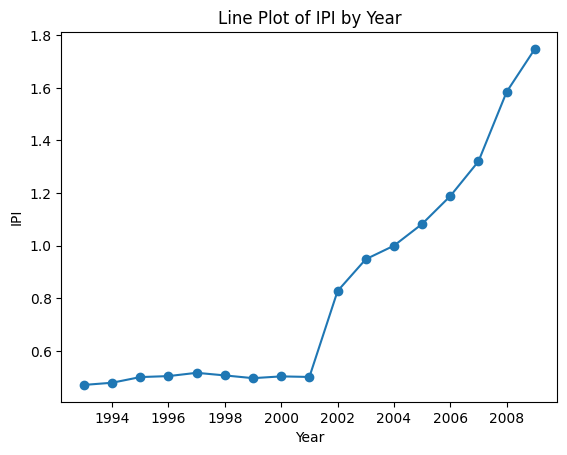

In [19]:
data_ipi = data_enge.loc[data_enge['year']<2010, ['year', 'ipi_empalme_04']].drop_duplicates()
# Create the line plot
plt.plot(data_ipi['year'], data_ipi['ipi_empalme_04'], marker='o')

# Set labels and title
plt.xlabel('Year')
plt.ylabel('IPI')
plt.title('Line Plot of IPI by Year')

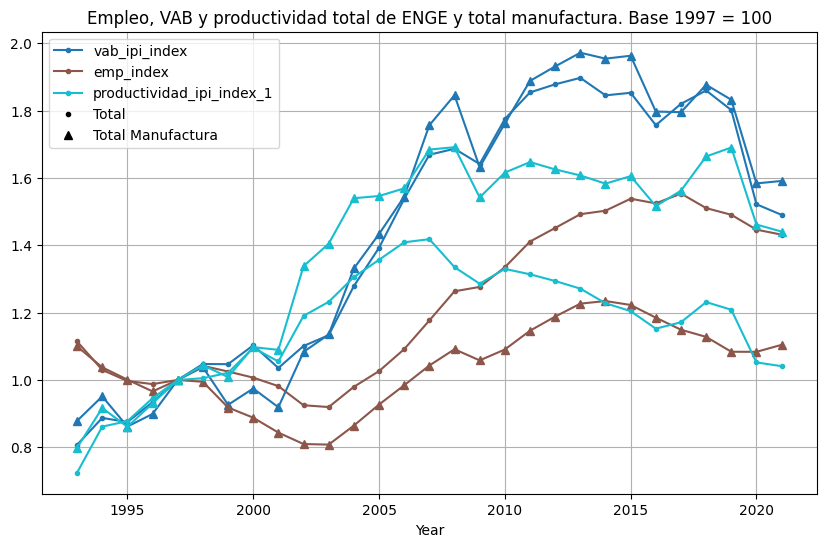

In [20]:
sectors = ['Total',    'Total Manufactura'] # 'Minas y canteras',

df_sel_index = data_enge.loc[data_enge['sector'].isin(sectors), ['year', 'sector',  'vab_ipi_index', 'emp_index',
                                                                 'productividad_ipi_index_1', ]] # 'ipi_empalme_04',


# Extract variables for plotting
x = df_sel_index['year']
y_vars = df_sel_index.columns[2:]  # Select all columns except 'year' and 'sector'
sectors = df_sel_index['sector'].unique()

# Create a color map for the variables
colors = plt.cm.get_cmap('tab10', len(y_vars))
markers = ['.', '^']

# Create the line plot
plt.figure(figsize=(10, 6))
for i, var in enumerate(y_vars):
    for j, sector in enumerate(sectors):
        df_sector = df_sel_index[df_sel_index['sector'] == sector]
        plt.plot(df_sector['year'], df_sector[var], color=colors(i), marker=markers[j], label=var if j == 0 else None)

# Set labels and title
plt.xlabel('Year')
plt.ylabel('')
title = 'Empleo, VAB y productividad total de ENGE y total manufactura. Base 1997 = 100'
plt.title(title)

# Add a legend
handles, labels = plt.gca().get_legend_handles_labels()
handles.extend([plt.Line2D([], [], color='black', marker=marker, linestyle='None') for marker in markers])
labels.extend(sectors)
plt.legend(handles, labels)

plt.grid(True)  # Add a grid
plt.savefig('../results/enge/' + title + '.png')
# Show the plot
plt.show()

In [21]:
data_enge['sector'].unique()

array(['Alimentos, bebidas y tabaco',
       'Combustibles, quimicos y plasticos', 'Comunicaciones',
       'Electricidad, gas y agua', 'Maquinarias, equipos y vehiculos',
       'Minas y canteras', 'Resto industria', 'Total',
       'Total Manufactura'], dtype=object)

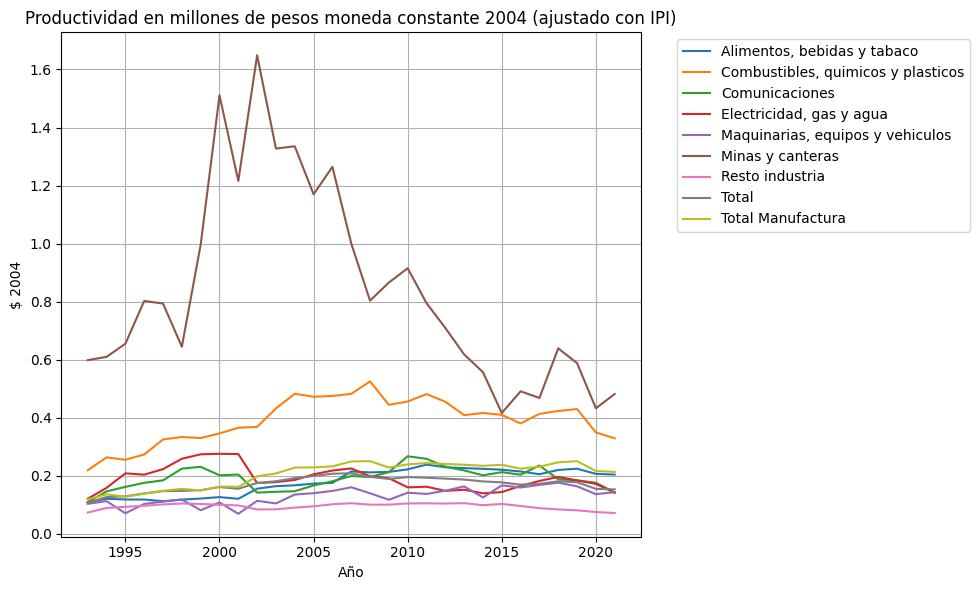

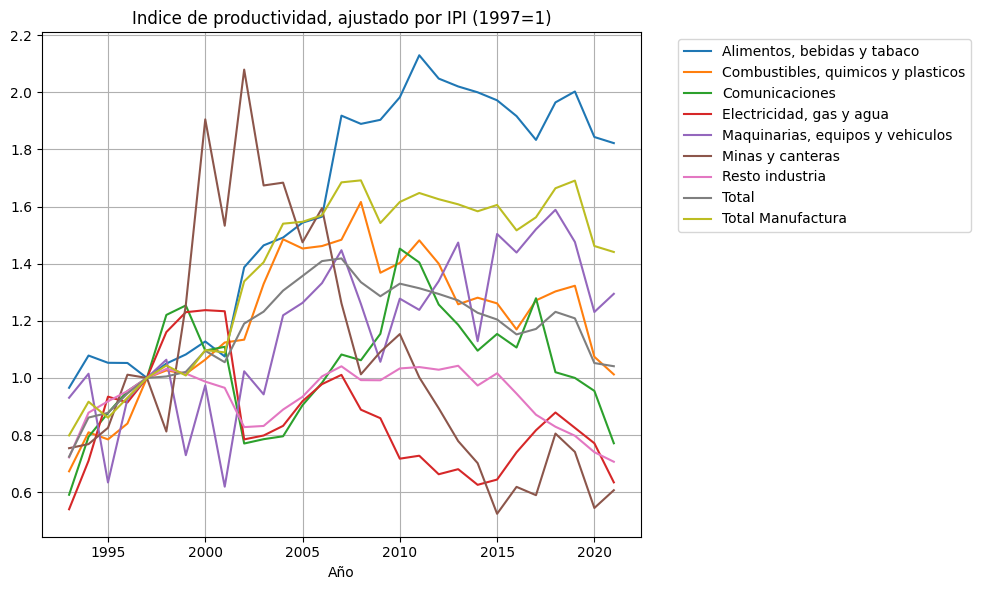

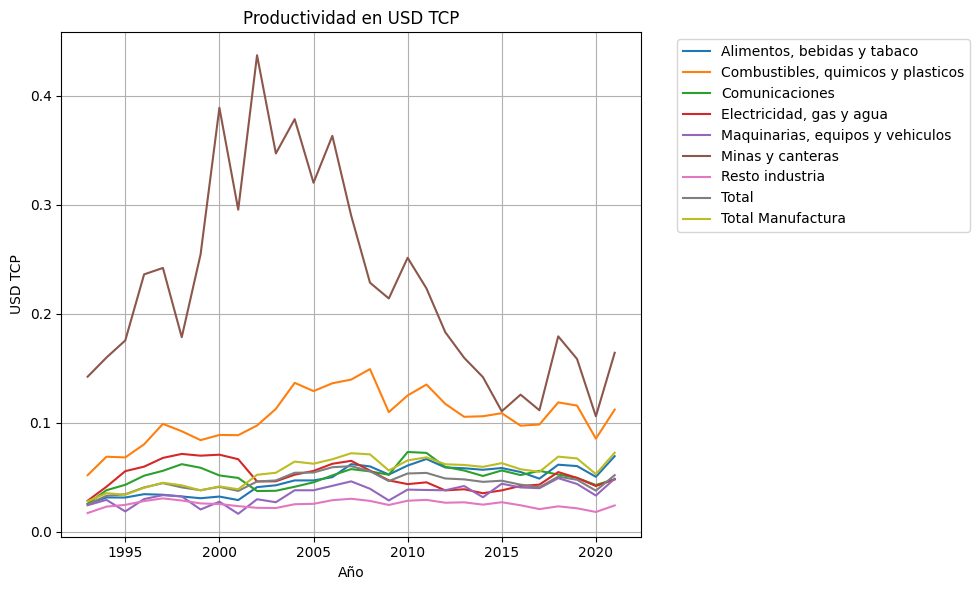

In [22]:
sectors = ['Total',    'Total Manufactura'] # 'Minas y canteras',
# data_plot = data_enge[data_enge['sector'].isin(sectors)]
# data_plot = data_enge[data_enge['sector'] != 'Minas y canteras' ]
data_plot = data_enge

for variable, title, axis_y in zip(['productividad_ipi_level', 'productividad_ipi_index_1',  'productividad_tcp_1_level'], 
                                   ['Productividad en millones de pesos moneda constante 2004 (ajustado con IPI)',  'Indice de productividad, ajustado por IPI (1997=1)', 'Productividad en USD TCP' ], 
                                   ['$ 2004', '',  'USD TCP']):
    

    plt.figure(figsize=(10, 6))  # Adjust the figure size if needed

    # Group the data by sector and plot each group separately
    for sector, data in data_plot.groupby('sector'):
        plt.plot(data['year'], data[variable], label=sector)

    plt.xlabel('Año')
    plt.ylabel(axis_y)
    plt.title(title)
    # plt.legend()  # Show the legend with sector labels
    # Place the legend outside the plot on the right side
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)  # Add a grid
    # Adjust the layout of the figure to accommodate the legend
    plt.tight_layout()
    plt.savefig('../results/enge/' + title + '.png')

    plt.show()
    
    

## Brecha productividad (vs manufactura total)

In [23]:
data_tot = pd.read_csv('../data/arg/va_manuf_arg.csv', skiprows=3)
data_tot = data_tot[['year',  'vab_tot_04', 'emp_tot', 'productividad_manuf_97'  ]]
data_tot = data_tot.replace(',', '', regex=True)
data_tot['vab_tot_04'] = data_tot['vab_tot_04'].astype(int)
data_tot['productividad_manuf_97'] = data_tot['productividad_manuf_97'] / 100
data_tot.info()

#unidades
## vab = pesos ajustados por IPI
## emp = puestos de trabajo asalariados (cantidad)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   year                    30 non-null     int64  
 1   vab_tot_04              30 non-null     int32  
 2   emp_tot                 30 non-null     int64  
 3   productividad_manuf_97  30 non-null     float64
dtypes: float64(1), int32(1), int64(2)
memory usage: 968.0 bytes


In [24]:
data_enge_manuf = data_enge.loc[data_enge['sector']=='Total Manufactura', ['year',  'emp','vab_ipi',  'productividad_ipi_index_1' ]]

In [25]:
data_enge2  = pd.merge(data_enge_manuf,
         data_tot,
         how = 'left',
         on = 'year')

data_enge2['sector'] = 'Total Manufactura sin ENGE'

data_enge2['vab_sin_enge'] =  data_enge2['vab_tot_04'] - data_enge2['vab_ipi']
data_enge2['emp_sin_enge'] = data_enge2['emp_tot'] - data_enge2['emp']

data_enge2['vab_sin_enge_index'] = get_index(data_enge2, 'vab_sin_enge', 1997)
data_enge2['emp_sin_enge_index'] = get_index(data_enge2, 'emp_sin_enge', 1997)

data_enge2['productividad_sin_enge_index'] = data_enge2['vab_sin_enge_index']/data_enge2['emp_sin_enge_index']

data_enge2['productividad_tot_level'] =  data_enge2['vab_tot_04']/data_enge2['emp_tot']
data_enge2['productividad_enge_level'] = data_enge2['vab_ipi']/data_enge2['emp']
data_enge2['productividad_sin_enge_level'] = data_enge2['vab_sin_enge']/data_enge2['emp_sin_enge']

data_enge2['brecha_productividad_enge_tot_level'] = data_enge2['productividad_enge_level']/ data_enge2['productividad_tot_level']
data_enge2['brecha_productividad_sin_enge_tot_level'] = data_enge2['productividad_sin_enge_level']/ data_enge2['productividad_tot_level']

data_enge2['peso_vab_enge'] = data_enge2['vab_ipi']/ data_enge2['vab_tot_04'] 
data_enge2['peso_emp_enge'] = data_enge2['emp']/ data_enge2['emp_tot'] 


data_enge2.head(3)


,year,emp,vab_ipi,productividad_ipi_index_1,vab_tot_04,emp_tot,productividad_manuf_97,sector,vab_sin_enge,emp_sin_enge,vab_sin_enge_index,emp_sin_enge_index,productividad_sin_enge_index,productividad_tot_level,productividad_enge_level,productividad_sin_enge_level,brecha_productividad_enge_tot_level,brecha_productividad_sin_enge_tot_level,peso_vab_enge,peso_emp_enge
0,1993,293052.0,34599.858995,0.798861,91639,2128972,0.753,Total Manufactura sin ENGE,57039.141005,1835920.0,0.937346,1.234429,0.759336,0.043044,0.118067,0.031068,2.742959,0.721787,0.377567,0.137650
1,1994,276471.0,37459.116384,0.916747,95045,1947301,0.854,Total Manufactura sin ENGE,57585.883616,1670830.0,0.946331,1.123426,0.842362,0.048809,0.135490,0.034465,2.775951,0.706135,0.394120,0.141977
2,1995,266714.0,33935.169539,0.860886,87574,1777968,0.862,Total Manufactura sin ENGE,53638.830461,1511254.0,0.881468,1.016131,0.867474,0.049255,0.127234,0.035493,2.583170,0.720594,0.387503,0.150011


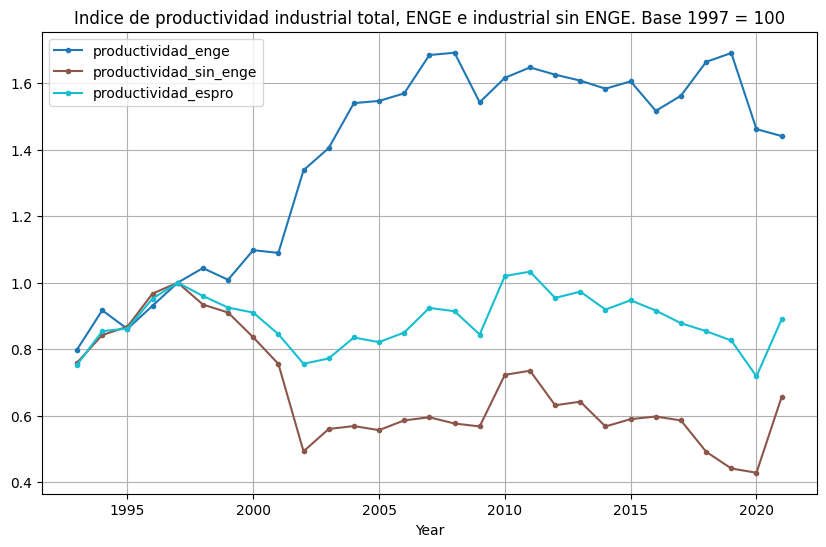

In [26]:
# df_sel_index = data_enge2[['year', 'sector',  'productividad_ipi_index_1', 'vab_sin_enge_index', 'emp_sin_enge_index',   'productividad_sin_enge_index', 'productividad_manuf_97']]
df_sel_index = data_enge2[['year', 'sector',  'productividad_ipi_index_1',  'productividad_sin_enge_index', 'productividad_manuf_97']]
df_sel_index.columns = ['year', 'sector',  'productividad_enge',  'productividad_sin_enge', 'productividad_espro']

title = 'Indice de productividad industrial total, ENGE e industrial sin ENGE. Base 1997 = 100'

# Extract variables for plotting
x = df_sel_index['year']
y_vars = df_sel_index.columns[2:]  # Select all columns except 'year' and 'sector'
sectors = df_sel_index['sector'].unique()

# Create a color map for the variables
colors = plt.cm.get_cmap('tab10', len(y_vars))
markers = ['.']

# Create the line plot
plt.figure(figsize=(10, 6))
for i, var in enumerate(y_vars):
    for j, sector in enumerate(sectors):
        df_sector = df_sel_index[df_sel_index['sector'] == sector]
        plt.plot(df_sector['year'], df_sector[var], color=colors(i), marker=markers[j], label=var if j == 0 else None)

# Set labels and title
plt.xlabel('Year')
plt.ylabel('')
plt.title(title)

# Add a legend
handles, labels = plt.gca().get_legend_handles_labels()
# handles.extend([plt.Line2D([], [], color='black', marker=marker, linestyle='None') for marker in markers])
labels.extend(sectors)
plt.legend(handles, labels)

plt.grid(True)  # Add a grid

plt.savefig('../results/enge/' + title + '.png')
# Show the plot
plt.show()


In [27]:
data_enge2.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 29 entries, 0 to 28
Data columns (total 20 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   year                                     29 non-null     int64  
 1   emp                                      29 non-null     float64
 2   vab_ipi                                  29 non-null     float64
 3   productividad_ipi_index_1                29 non-null     float64
 4   vab_tot_04                               29 non-null     int32  
 5   emp_tot                                  29 non-null     int64  
 6   productividad_manuf_97                   29 non-null     float64
 7   sector                                   29 non-null     object 
 8   vab_sin_enge                             29 non-null     float64
 9   emp_sin_enge                             29 non-null     float64
 10  vab_sin_enge_index                       29 non-null

In [28]:
data_enge2.columns = ['year', 'emp_enge', 'vab_ipi_enge',  'productividad_enge_index_1',
                      'vab_ipi_tot_manuf', 'emp_tot_manuf', 'productividad_tot_manuf_index',
                      'sector',
                      'vab_ipi_sin_enge', 'emp_sin_enge', 'vab_ipi_sin_enge_index', 'emp_sin_enge_index',
                      'productividad_sin_enge_index', 'productividad_tot_level', 
                      'productividad_enge_level', 'productividad_sin_enge_level',
                      'brecha_productividad_enge_tot_level', 'brecha_productividad_sin_enge_tot_level',
                      'peso_vab_enge', 'peso_emp_enge']
data_enge2.to_excel("../results/enge/enge_y_total.xlsx") 


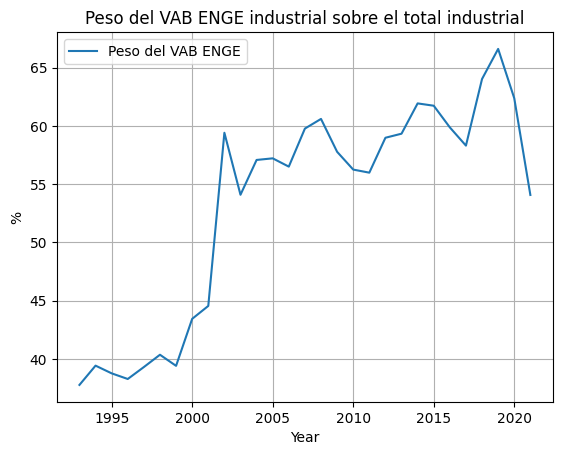

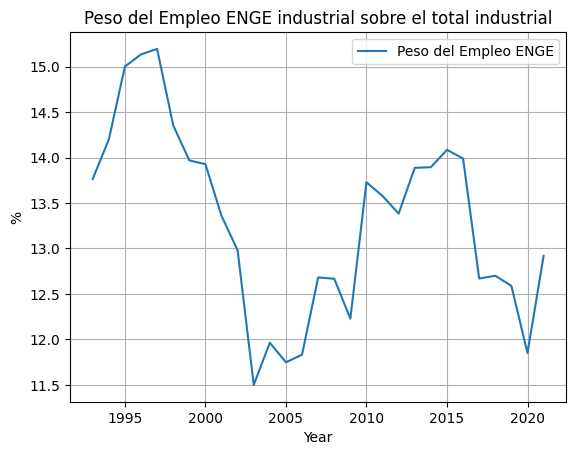

In [29]:
data_peso_plot = data_enge2[['year', 'peso_vab_enge', 'peso_emp_enge']]

year = data_peso_plot['year']
peso_vab_enge = data_peso_plot['peso_vab_enge'] *100
peso_emp_enge = data_peso_plot['peso_emp_enge'] *100

for  var, label in zip([peso_vab_enge, peso_emp_enge], ['Peso del VAB ENGE', 'Peso del Empleo ENGE']):
    # Create the line plot
    plt.plot(year, var, label=label)
    # plt.plot(year, peso_emp_enge, label='Peso Emp ENGE')

    plt.xlabel('Year')
    plt.ylabel('%')
    title = f'{label} industrial sobre el total industrial'
    plt.title(title)

    plt.legend()
    plt.grid(True)
    plt.savefig('../results/enge/' + title + '.png')

    plt.show()

In [30]:
# df_sel_index = data_enge2[['year', 'sector',  'peso_vab_enge',  'peso_emp_enge']

## Brecha EEUU 

count    29.000000
mean      4.055663
std       0.907305
min       2.528456
25%       3.118347
50%       4.382485
75%       4.724046
max       5.290910
Name: brecha_productividad_enge_tot_level, dtype: float64

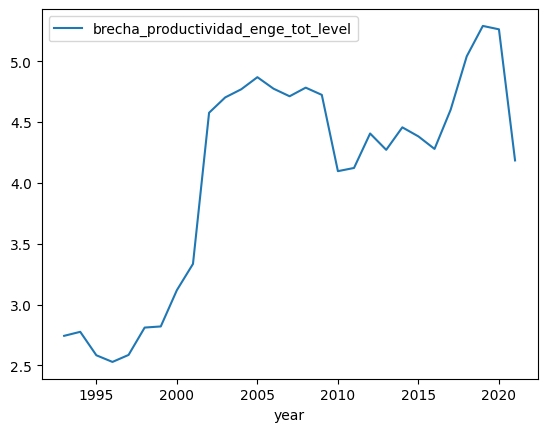

In [31]:
# data_enge2.info()
data_enge2.plot(x='year', y='brecha_productividad_enge_tot_level')
data_enge2.brecha_productividad_enge_tot_level.describe()

count    29.000000
mean      0.540593
std       0.113249
min       0.382058
25%       0.466476
50%       0.487624
75%       0.657234
max       0.727430
Name: brecha_productividad_sin_enge_tot_level, dtype: float64

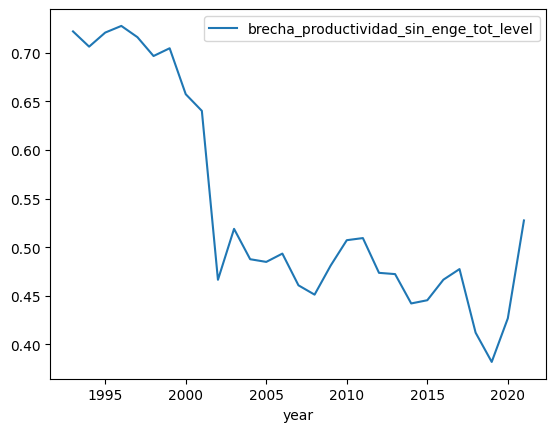

In [32]:
data_enge2.plot(x='year', y='brecha_productividad_sin_enge_tot_level')
data_enge2.brecha_productividad_sin_enge_tot_level.describe()

In [33]:
eeuu_prod = pd.read_csv('../data/arg/eeuu_prod.csv', skiprows = 4)
eeuu_prod.columns =['year', 'prod_arg', 'prod_eeuu', 'brecha']
eeuu_prod.dropna(subset = ['brecha'], axis = 0, inplace= True)
eeuu_prod['brecha_productividad_eeuu_arg'] =  eeuu_prod['brecha'] / 100

eeuu_prod.info()
eeuu_prod.tail(3)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 45 entries, 1 to 45
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   year                           45 non-null     int64  
 1   prod_arg                       45 non-null     float64
 2   prod_eeuu                      45 non-null     float64
 3   brecha                         45 non-null     float64
 4   brecha_productividad_eeuu_arg  45 non-null     float64
dtypes: float64(4), int64(1)
memory usage: 2.1 KB


,year,prod_arg,prod_eeuu,brecha,brecha_productividad_eeuu_arg
43,2016,91.64,168.32,12.4,0.124
44,2017,87.79,168.11,11.8,0.118
45,2018,85.35,168.68,11.5,0.115


<AxesSubplot:xlabel='year'>

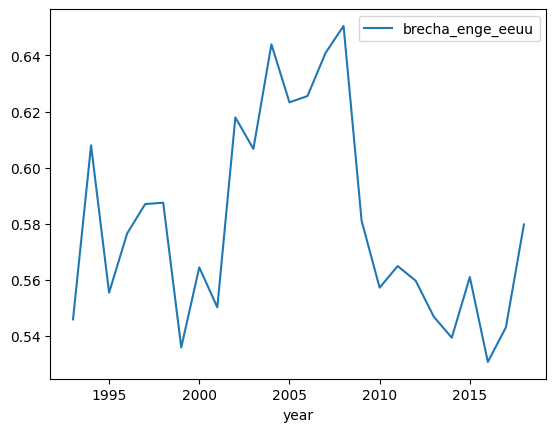

In [34]:
brecha_enge_eeuu_df = pd.merge(data_enge2[['year',  'brecha_productividad_enge_tot_level', 'brecha_productividad_sin_enge_tot_level']],
                               eeuu_prod[['year',  'brecha_productividad_eeuu_arg']],
                                how = 'left', on = 'year')
brecha_enge_eeuu_df['brecha_enge_eeuu'] = brecha_enge_eeuu_df['brecha_productividad_enge_tot_level'] * brecha_enge_eeuu_df['brecha_productividad_eeuu_arg']                 
brecha_enge_eeuu_df['brecha_sin_enge_eeuu'] = brecha_enge_eeuu_df['brecha_productividad_sin_enge_tot_level'] * brecha_enge_eeuu_df['brecha_productividad_eeuu_arg']                 
brecha_enge_eeuu_df[['year', 'brecha_enge_eeuu']].set_index('year').plot()

<AxesSubplot:xlabel='year'>

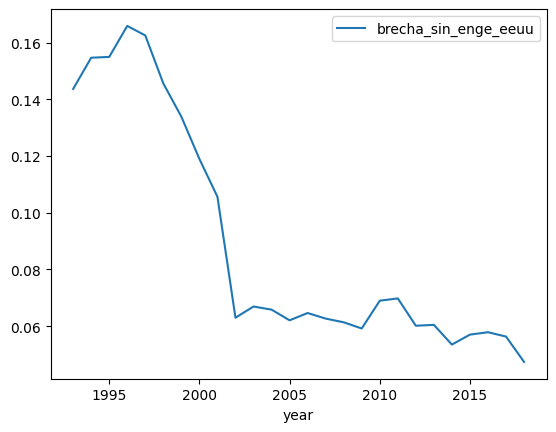

In [35]:
brecha_enge_eeuu_df[['year', 'brecha_sin_enge_eeuu']].set_index('year').plot()

In [36]:
brecha_enge_eeuu_df.to_excel("../results/enge/brecha_enge_eeuu.xlsx") 